<span style="color:#4FA3FF; font-weight:700; font-size:120%">Optimización de Portafolios con Markowitz mediante Simulación Monte Carlo</span>

<span style="color:#4FA3FF; font-weight:700">Descripción breve:</span>

Este trabajo presenta una metodología práctica para **optimizar portafolios** utilizando el enfoque de **Markowitz** combinado con **Simulación Monte Carlo**. A partir de datos históricos obtenidos con `yfinance` se generan múltiples combinaciones de pesos para estimar el **retorno esperado**, la **volatilidad** y el **Ratio de Sharpe**.

El objetivo es identificar la **combinación más eficiente** (máximo Sharpe) y construir la **frontera eficiente** para facilitar la toma de decisiones según distintos perfiles de riesgo.

<span style="color:#4FA3FF; font-weight:700">Componentes esenciales</span>

<span style="color:#4FA3FF; font-weight:700">Datos y Preparación</span>

Se emplean ETFs y acciones reales (por ejemplo: GOOGL, NVDA, MSFT, entre otros).

Se obtienen precios históricos a través de `yfinance` y se calculan retornos diarios, que sirven como base para las simulaciones.

<span style="color:#4FA3FF; font-weight:700">Simulación Monte Carlo</span>

Se generan 100.000 (configurable) combinaciones aleatorias de pesos entre los activos. Para cada portafolio se estiman:

- **Retorno esperado**
- **Volatilidad total**
- **Ratio de Sharpe** (medida de eficiencia riesgo-rendimiento)

<span style="color:#4FA3FF; font-weight:700">Optimización</span>

Se identifica el portafolio con mayor **Sharpe Ratio**, considerado el más eficiente bajo las suposiciones del modelo.

Se construye la **frontera eficiente** y los resultados se visualizan con un gráfico de dispersión riesgo-retorno (volatilidad vs. retorno) con el Sharpe codificado por color.

<span style="color:#4FA3FF; font-weight:700">Aplicación práctica</span>

El programa permite:

- Determinar la combinación óptima de activos según la muestra histórica.
- Analizar visualmente la relación **riesgo vs rendimiento**.
- Evaluar el nivel de diversificación del portafolio.
- Ajustar decisiones según el perfil de riesgo del inversor y parámetros (p. ej. tasa libre de riesgo, número de simulaciones).

<span style="color:#4FA3FF; font-weight:700">Consideraciones</span>

- Las conclusiones dependen de datos históricos y de la ventana temporal analizada.
- Se asume una distribución aproximada de retornos (limitación del modelo).
- Los pesos en esta versión son solo positivos (sin posiciones cortas).
- Se recomienda rebalanceo periódico y validación con escenarios fuera de muestra.

(Los bloques siguientes contienen el código para descargar datos, calcular retornos, ejecutar la simulación Monte Carlo y graficar la frontera eficiente).

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Descarga los precios históricos ajustados de los activos seleccionados (maneja cambios en yfinance)
def get_stock_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        # Solicita los datos sin modificar automáticamente los precios (auto_adjust=False)
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
        # yfinance puede devolver DataFrame con columna 'Adj Close' o solo 'Close'.
        # Seleccionamos 'Adj Close' si existe, sino 'Close'. Si la respuesta es una Series, la usamos directamente.
        if isinstance(df, pd.Series):
            series = df
        else:
            if 'Adj Close' in df.columns:
                series = df['Adj Close']
            elif 'Close' in df.columns:
                series = df['Close']
            else:
                # Fallback: tomar la primera columna disponible
                series = df.iloc[:, 0]
        data[ticker] = series
    return data

# Definición de los activos y parámetros de consulta
stocks = ["GOOGL", "ASML", "MOH", "ORLA",
            "NVDA", "META", "BKNG", "LEN",
            "PFE", "KHC", "MSFT","FLR",
            "GRBK", "UPS", "PDD",
            "PG", "UNH", "BIDU"]

start_date = '2019-01-01'
end_date = '2025-01-01'

# Obtiene los datos históricos para los activos definidos
stock_data = get_stock_data(stocks, start_date, end_date)

stock_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%*******

,GOOGL,ASML,MOH,ORLA,NVDA,META,BKNG,LEN,PFE,KHC,MSFT,FLR,GRBK,UPS,PDD,PG,UNH,BIDU
Date,,,,,,,,,,,,,,,,,,
2019-01-02,52.372780,145.733459,112.889999,0.795,3.377166,134.848709,1693.982056,35.530613,29.785063,30.856236,94.612602,31.620932,7.45,73.938759,22.209999,76.454636,218.588013,162.250000
2019-01-03,50.922283,137.696182,105.900002,0.872,3.173128,130.932861,1636.345093,35.166050,28.951777,30.834873,91.131973,31.073757,7.57,71.839478,21.520000,75.918579,212.627075,154.710007
2019-01-04,53.534267,143.654205,109.660004,0.872,3.376423,137.104782,1689.898804,36.642052,29.612902,31.674990,95.370483,32.753681,7.67,74.341873,22.690001,77.468117,215.113785,160.949997
2019-01-07,53.427505,146.936234,117.750000,0.875,3.555173,137.204193,1684.260986,37.682369,29.771296,32.273037,95.492111,33.512047,8.06,74.090874,23.209999,77.158218,215.526764,162.600006
2019-01-08,53.896770,145.854645,128.309998,0.875,3.466665,141.656723,1659.761963,38.135818,29.909035,32.301514,96.184509,33.876831,8.29,74.098495,24.000000,77.442993,218.408463,163.399994


In [25]:
# Calcula los retornos diarios simples de cada activo
returns = stock_data.pct_change()  # Retornos porcentuales diarios

returns.head()

,GOOGL,ASML,MOH,ORLA,NVDA,META,BKNG,LEN,PFE,KHC,MSFT,FLR,GRBK,UPS,PDD,PG,UNH,BIDU
Date,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.027696,-0.055151,-0.061919,0.096855,-0.060417,-0.029039,-0.034025,-0.010261,-0.027977,-0.000692,-0.036788,-0.017304,0.016107,-0.028392,-0.031067,-0.007011,-0.027270,-0.046471
2019-01-04,0.051294,0.043269,0.035505,0.000000,0.064068,0.047138,0.032728,0.041972,0.022835,0.027246,0.046510,0.054062,0.013210,0.034833,0.054368,0.020411,0.011695,0.040333
2019-01-07,-0.001994,0.022847,0.073773,0.003440,0.052941,0.000725,-0.003336,0.028391,0.005349,0.018881,0.001275,0.023154,0.050848,-0.003376,0.022918,-0.004000,0.001920,0.010252
2019-01-08,0.008783,-0.007361,0.089682,0.000000,-0.024896,0.032452,-0.014546,0.012033,0.004627,0.000882,0.007251,0.010885,0.028536,0.000103,0.034037,0.003691,0.013370,0.004920


In [26]:
# Simulación Monte Carlo para portafolios aleatorios

# Parámetros principales de la simulación
num_portfolios = 100000
rf_rate = 0.04  # Tasa libre de riesgo anual (4%)

# Inicializa los arreglos para almacenar los resultados de cada portafolio
all_weights = np.zeros((num_portfolios, len(stocks)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

# Ejecuta la simulación generando portafolios aleatorios
for port in range(num_portfolios):
    # Genera pesos aleatorios y los normaliza para que sumen 1
    weights = np.random.random(len(stocks))
    weights = weights/np.sum(weights)  # Normalización de pesos
    all_weights[port,:] = weights
    
    # Calcula el retorno anual esperado del portafolio
    port_ret = np.sum(returns.mean() * weights) * 252
    ret_arr[port] = port_ret
    
    # Calcula la volatilidad anual del portafolio
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    vol_arr[port] = port_vol
    
    # Calcula el Ratio de Sharpe para el portafolio
    sharpe_arr[port] = (port_ret - rf_rate) / port_vol

In [27]:
# Identifica el portafolio óptimo según el mayor Ratio de Sharpe
optimal_idx = sharpe_arr.argmax()
optimal_weights = all_weights[optimal_idx,:]
optimal_ret = ret_arr[optimal_idx]
optimal_vol = vol_arr[optimal_idx]
optimal_sharpe = sharpe_arr[optimal_idx]

# Crea un DataFrame con los resultados de todos los portafolios simulados
results = pd.DataFrame({
    'Return': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr
})

![MarkImage.png](MarkImage.png)

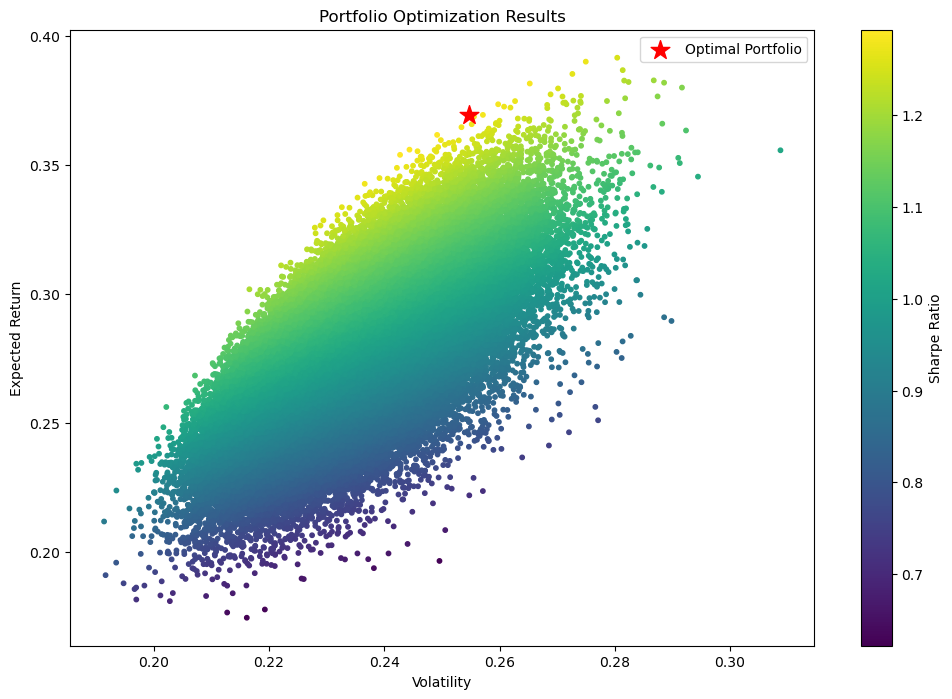


Portafolio Óptimo:
--------------------
Retorno Esperado: 36.92%
Volatilidad: 25.46%
Ratio de Sharpe: 1.29

Pesos óptimos:
GOOGL: 12.03%
ASML: 1.47%
MOH: 3.60%
ORLA: 11.84%
NVDA: 13.55%
META: 8.14%
BKNG: 2.27%
LEN: 8.16%
PFE: 4.46%
KHC: 1.22%
MSFT: 2.82%
FLR: 0.31%
GRBK: 2.92%
UPS: 0.15%
PDD: 12.33%
PG: 12.79%
UNH: 1.19%
BIDU: 0.74%


In [28]:
# Visualiza la frontera eficiente y el portafolio óptimo
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_vol, optimal_ret, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Portfolio Optimization Results')
plt.legend()
plt.show()

# Muestra los resultados del portafolio óptimo
print("\nPortafolio Óptimo:")
print("--------------------")
print(f"Retorno Esperado: {optimal_ret*100:.2f}%")
print(f"Volatilidad: {optimal_vol*100:.2f}%")
print(f"Ratio de Sharpe: {optimal_sharpe:.2f}")
print("\nPesos óptimos:")
for stock, weight in zip(stocks, optimal_weights):
    print(f"{stock}: {weight*100:.2f}%")